In [1]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# custom modules
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining
from src.model_building.eval_model import ModelEvaluator
from src.utils import *
from config.paths import *

In [3]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 
build_model = ModelTraining(PROJECT_PATH)

### Data Ingestion

In [4]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

dam data is already updated up to:  2024-01-16 23:45:00
rtm data updated up to:  15-01-2024 20:45


In [5]:
weather = load_pickle(PROCESSED_DATA_PATH, 'weather_data')
wind = load_pickle(PROCESSED_DATA_PATH, 'wind_data')
hydro = load_pickle(PROCESSED_DATA_PATH, 'hydro_data')
solar = load_pickle(PROCESSED_DATA_PATH, 'solar_data')

In [6]:
rtm = rtm[rtm['datetime'] < datetime.now().strftime('%Y-%m-%d')]

### Feature Engineering

In [7]:
dam = featured_data.shift_date(dam, 1) 
weather = featured_data.shift_date(weather, 2)
hydro = featured_data.shift_date(hydro, 2) 
solar = featured_data.shift_date(solar, 2) 
wind = featured_data.shift_date(wind, 2)

data = featured_data.merge_dataframes([rtm, dam, weather, hydro, solar, wind])

In [8]:
training_data = featured_data._get_features(data, weather, market_type = 'rtm')

In [9]:
save_pickle(training_data, PROCESSED_DATA_PATH, f'rtm_training_data')

### Model Building

In [10]:
training_data = load_pickle(PROCESSED_DATA_PATH, 'rtm_training_data')

In [11]:
# Set the desired cutoff dates
training_upto = training_data.iloc[int(training_data.shape[0]*0.9)]['datetime'].strftime('%Y-%m-%d')      # 80% data for training
validation_upto = training_data.iloc[int(training_data.shape[0]*0.95)]['datetime'].strftime('%Y-%m-%d')        # last day data for testing

# Split the data
X_train, y_train, X_valid, y_valid, X_test, y_test = build_model._split_data(training_data, training_upto, validation_upto)

In [12]:
# trail and error
n_trials = 20
n_features = 20

In [13]:
best_features, best_params = build_model._features_n_params(X_train, y_train, X_valid, y_valid, n_trials, n_features)

[I 2024-01-15 20:18:36,886] A new study created in memory with name: no-name-b18a37ee-7ea3-444b-9530-5b71593ea81a
[I 2024-01-15 20:18:37,281] Trial 0 finished with value: 32.97 and parameters: {'n_estimators': 900, 'lambda_l1': 20.0, 'lambda_l2': 60.0, 'num_leaves': 6800, 'min_data_in_leaf': 5400, 'max_bin': 224, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 2, 'min_gain_to_split': 4.5996667552922315, 'max_depth': 14, 'learning_rate': 0.19}. Best is trial 0 with value: 32.97.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.0402756512207723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0402756512207723
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


[I 2024-01-15 20:18:39,177] Trial 1 finished with value: 26.67 and parameters: {'n_estimators': 800, 'lambda_l1': 55.0, 'lambda_l2': 75.0, 'num_leaves': 4650, 'min_data_in_leaf': 1600, 'max_bin': 299, 'feature_fraction': 0.7, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 3.0402756512207723, 'max_depth': 8, 'learning_rate': 0.12}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=13.457426617592775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.457426617592775
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-15 20:18:39,516] Trial 2 finished with value: 33.1 and parameters: {'n_estimators': 400, 'lambda_l1': 100.0, 'lambda_l2': 55.0, 'num_leaves': 3200, 'min_data_in_leaf': 4300, 'max_bin': 242, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.4, 'bagging_freq': 6, 'min_gain_to_split': 13.457426617592775, 'max_depth': 8, 'learning_rate': 0.22}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=10.385763770128293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.385763770128293
[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0


[I 2024-01-15 20:18:39,808] Trial 3 finished with value: 33.99 and parameters: {'n_estimators': 900, 'lambda_l1': 80.0, 'lambda_l2': 85.0, 'num_leaves': 700, 'min_data_in_leaf': 8100, 'max_bin': 262, 'feature_fraction': 0.7, 'bagging_fraction': 0.3, 'bagging_freq': 5, 'min_gain_to_split': 10.385763770128293, 'max_depth': 6, 'learning_rate': 0.28}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=6.315378888614095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.315378888614095
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-15 20:18:40,403] Trial 4 finished with value: 29.61 and parameters: {'n_estimators': 900, 'lambda_l1': 5.0, 'lambda_l2': 45.0, 'num_leaves': 450, 'min_data_in_leaf': 4800, 'max_bin': 273, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 6.315378888614095, 'max_depth': 4, 'learning_rate': 0.24000000000000002}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.2046877906099613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2046877906099613
[LightGBM] [Warning] lambda_l1 is set=20.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.0


[I 2024-01-15 20:18:40,865] Trial 5 finished with value: 32.26 and parameters: {'n_estimators': 800, 'lambda_l1': 20.0, 'lambda_l2': 15.0, 'num_leaves': 9650, 'min_data_in_leaf': 1700, 'max_bin': 248, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 1, 'min_gain_to_split': 1.2046877906099613, 'max_depth': 4, 'learning_rate': 0.08}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.5364636553830682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5364636553830682
[LightGBM] [Warning] lambda_l1 is set=40.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40.0


[I 2024-01-15 20:18:41,298] Trial 6 finished with value: 33.95 and parameters: {'n_estimators': 100, 'lambda_l1': 40.0, 'lambda_l2': 95.0, 'num_leaves': 5450, 'min_data_in_leaf': 8500, 'max_bin': 241, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 6, 'min_gain_to_split': 0.5364636553830682, 'max_depth': 10, 'learning_rate': 0.05}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=9.277604992019342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.277604992019342
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-15 20:18:41,867] Trial 7 finished with value: 29.89 and parameters: {'n_estimators': 1000, 'lambda_l1': 100.0, 'lambda_l2': 75.0, 'num_leaves': 5550, 'min_data_in_leaf': 4300, 'max_bin': 229, 'feature_fraction': 0.8, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'min_gain_to_split': 9.277604992019342, 'max_depth': 10, 'learning_rate': 0.2}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=13.658021952629035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.658021952629035
[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0


[I 2024-01-15 20:18:42,134] Trial 8 finished with value: 33.69 and parameters: {'n_estimators': 1000, 'lambda_l1': 45.0, 'lambda_l2': 100.0, 'num_leaves': 4100, 'min_data_in_leaf': 8100, 'max_bin': 230, 'feature_fraction': 0.3, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 2, 'min_gain_to_split': 13.658021952629035, 'max_depth': 3, 'learning_rate': 0.15000000000000002}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=11.838069791348122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.838069791348122
[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0


[I 2024-01-15 20:18:42,668] Trial 9 finished with value: 28.57 and parameters: {'n_estimators': 900, 'lambda_l1': 50.0, 'lambda_l2': 25.0, 'num_leaves': 350, 'min_data_in_leaf': 4700, 'max_bin': 285, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 5, 'min_gain_to_split': 11.838069791348122, 'max_depth': 15, 'learning_rate': 0.29000000000000004}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=4.050954845483867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.050954845483867
[LightGBM] [Warning] lambda_l1 is set=75.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75.0


[I 2024-01-15 20:18:43,248] Trial 10 finished with value: 31.31 and parameters: {'n_estimators': 600, 'lambda_l1': 75.0, 'lambda_l2': 35.0, 'num_leaves': 7750, 'min_data_in_leaf': 1700, 'max_bin': 294, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 7, 'min_gain_to_split': 4.050954845483867, 'max_depth': 12, 'learning_rate': 0.12}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.573200983630585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.573200983630585
[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0


[I 2024-01-15 20:18:46,415] Trial 11 finished with value: 29.64 and parameters: {'n_estimators': 700, 'lambda_l1': 60.0, 'lambda_l2': 15.0, 'num_leaves': 2150, 'min_data_in_leaf': 500, 'max_bin': 298, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'bagging_freq': 4, 'min_gain_to_split': 10.573200983630585, 'max_depth': 15, 'learning_rate': 0.01}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.957464640111674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.957464640111674
[LightGBM] [Warning] lambda_l1 is set=65.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65.0


[I 2024-01-15 20:18:46,957] Trial 12 finished with value: 28.23 and parameters: {'n_estimators': 400, 'lambda_l1': 65.0, 'lambda_l2': 0.0, 'num_leaves': 2850, 'min_data_in_leaf': 2800, 'max_bin': 280, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 7, 'min_gain_to_split': 7.957464640111674, 'max_depth': 7, 'learning_rate': 0.29000000000000004}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.385195408746698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.385195408746698
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0


[I 2024-01-15 20:18:47,594] Trial 13 finished with value: 28.35 and parameters: {'n_estimators': 400, 'lambda_l1': 70.0, 'lambda_l2': 0.0, 'num_leaves': 2950, 'min_data_in_leaf': 2500, 'max_bin': 276, 'feature_fraction': 1.0, 'bagging_fraction': 0.7, 'bagging_freq': 7, 'min_gain_to_split': 7.385195408746698, 'max_depth': 7, 'learning_rate': 0.12}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.881285659701719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.881285659701719
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-15 20:18:48,222] Trial 14 finished with value: 27.58 and parameters: {'n_estimators': 400, 'lambda_l1': 35.0, 'lambda_l2': 75.0, 'num_leaves': 4100, 'min_data_in_leaf': 2900, 'max_bin': 203, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'min_gain_to_split': 2.881285659701719, 'max_depth': 6, 'learning_rate': 0.15000000000000002}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=2.580925399373811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.580925399373811
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-15 20:18:48,746] Trial 15 finished with value: 27.71 and parameters: {'n_estimators': 200, 'lambda_l1': 25.0, 'lambda_l2': 65.0, 'num_leaves': 4450, 'min_data_in_leaf': 300, 'max_bin': 205, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 2.580925399373811, 'max_depth': 5, 'learning_rate': 0.16}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.2911923344845038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2911923344845038
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-15 20:18:49,142] Trial 16 finished with value: 32.87 and parameters: {'n_estimators': 600, 'lambda_l1': 35.0, 'lambda_l2': 75.0, 'num_leaves': 6600, 'min_data_in_leaf': 6500, 'max_bin': 202, 'feature_fraction': 0.5, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 3, 'min_gain_to_split': 3.2911923344845038, 'max_depth': 9, 'learning_rate': 0.09}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.610740799138291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.610740799138291
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


[I 2024-01-15 20:18:49,527] Trial 17 finished with value: 33.65 and parameters: {'n_estimators': 500, 'lambda_l1': 55.0, 'lambda_l2': 80.0, 'num_leaves': 8800, 'min_data_in_leaf': 3400, 'max_bin': 263, 'feature_fraction': 0.3, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 5.610740799138291, 'max_depth': 12, 'learning_rate': 0.16}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.080189171670103, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.080189171670103
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-15 20:18:50,295] Trial 18 finished with value: 27.22 and parameters: {'n_estimators': 300, 'lambda_l1': 0.0, 'lambda_l2': 65.0, 'num_leaves': 1700, 'min_data_in_leaf': 1600, 'max_bin': 214, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 2.080189171670103, 'max_depth': 6, 'learning_rate': 0.12}. Best is trial 1 with value: 26.67.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.0635735273989777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0635735273989777
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-15 20:18:50,666] Trial 19 finished with value: 33.0 and parameters: {'n_estimators': 200, 'lambda_l1': 5.0, 'lambda_l2': 45.0, 'num_leaves': 1650, 'min_data_in_leaf': 9900, 'max_bin': 217, 'feature_fraction': 0.4, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 0.0635735273989777, 'max_depth': 9, 'learning_rate': 0.05}. Best is trial 1 with value: 26.67.




Best MAPE achieved:  26.67


### Model Training

In [14]:
# training upto this date
training_upto = training_data[::96]['datetime'].iloc[-1].strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [15]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.0402756512207723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0402756512207723
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


In [16]:
save_pickle(model, MODELS_PATH, 'rtm_forecast')

### Model Evaluation

In [17]:
evaluator = ModelEvaluator(model, best_features)

Evaluating on train data:
MAPE: 6.226291396370888e+17


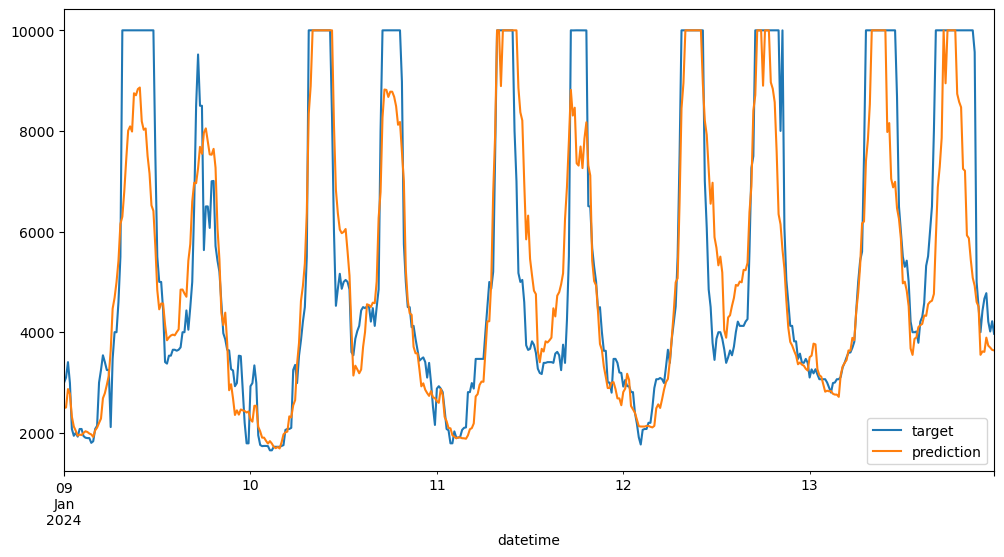

In [18]:
evaluator.evaluate_on_data(X_train, y_train, 'train', 5, 'rtm')

Evaluating on test data:
MAPE: 19.0


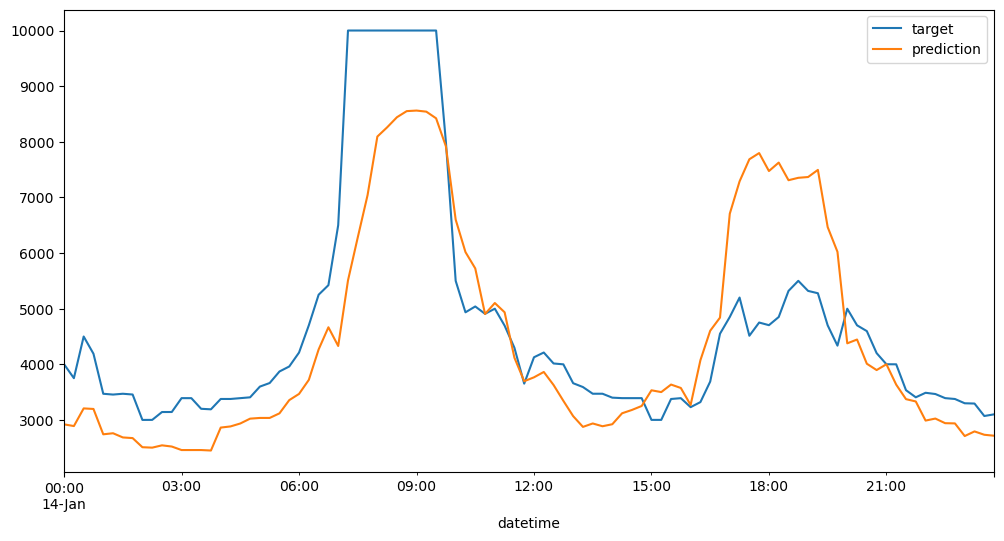

In [20]:
evaluator.evaluate_on_data(X_test, y_test, 'test', 1, 'rtm')